In [1]:
# Install required libraries
!pip install tonic --quiet
!pip install spikingjelly --quiet
!pip install torch torchvision --quiet
!pip install scikit-learn --quiet
!pip install tqdm --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.2/106.2 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 437.6/437.6 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.0 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from spikingjelly.clock_driven import neuron, functional, surrogate
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import tonic
from tonic import transforms, datasets
import time
import os
from tqdm.notebook import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

2025-07-08 02:38:23.567527: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751942303.944773      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751942304.052375      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
transform = transforms.ToVoxelGrid(sensor_size=(34, 34, 2), n_time_bins=30)

train_ds = datasets.NMNIST(
    save_to="/kaggle/working",
    train=True,
    transform=transform
)
test_ds = datasets.NMNIST(
    save_to="/kaggle/working",
    train=False,
    transform=transform
)

  0%|          | 0/1011893601 [00:00<?, ?it/s]

Extracting /kaggle/working/NMNIST/train.zip to /kaggle/working/NMNIST


  0%|          | 0/169674850 [00:00<?, ?it/s]

Extracting /kaggle/working/NMNIST/test.zip to /kaggle/working/NMNIST


In [4]:
class SpikingRNNROI(nn.Module):
    def __init__(self):
        super().__init__()
        # deeper conv stack with batch norm
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.bn1   = nn.BatchNorm2d(16)
        self.lif1  = neuron.LIFNode()
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn2   = nn.BatchNorm2d(32)
        self.lif2  = neuron.LIFNode()
        # mask head
        self.mask_conv = nn.Conv2d(32, 1, 1)
        self.sig       = nn.Sigmoid()

    def forward(self, x_seq):
        masks = []
        for x in x_seq:
            f = self.lif1(self.bn1(self.conv1(x)))
            f = self.lif2(self.bn2(self.conv2(f)))
            m = self.sig(self.mask_conv(f))
            masks.append(m)
        return masks

In [5]:
class LeNetSNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 12, kernel_size=5),
            neuron.LIFNode(),
            nn.MaxPool2d(2),
            nn.Conv2d(12, 32, kernel_size=5),
            neuron.LIFNode(),
            nn.MaxPool2d(2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 5 * 5, 100),
            neuron.LIFNode(),
            nn.Linear(100, 10)
        )

    def forward(self, x):
        x_seq = []
        for t in range(x.size(0)):
            out = self.conv_layers(x[t])
            out = self.fc_layers(out)
            x_seq.append(out)
        return sum(x_seq) / len(x_seq)

In [6]:
class CNNBaseline(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv3d(1, 16, kernel_size=(3, 5, 5), padding=(1, 2, 2)),
            nn.ReLU(),
            nn.MaxPool3d((1, 2, 2)),
            nn.Conv3d(16, 32, kernel_size=(3, 5, 5), padding=(1, 2, 2)),
            nn.ReLU(),
            nn.MaxPool3d((1, 2, 2))
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 30 * 8 * 8, 100),
            nn.ReLU(),
            nn.Linear(100, 10)
        )

    def forward(self, x):
        x = x.unsqueeze(1)
        x = x.permute(0, 1, 3, 2, 4, 5).reshape(-1, 1, 30, 34, 34)
        return self.fc(self.conv_layers(x))

In [7]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_ds,
    batch_size=32,
    shuffle=True,
    drop_last=True,
    num_workers=2,  
    pin_memory=True
)

test_loader = DataLoader(
    test_ds,
    batch_size=32,
    shuffle=False,
    drop_last=False,
    num_workers=2,
    pin_memory=True
)

In [8]:
import torch
import torch.nn as nn
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from spikingjelly.clock_driven import functional

def train_one_epoch(model, predictor, train_loader, optimizer, criterion, device):
    model.train()
    predictor.train()
    total_loss = 0
    total_correct = 0

    for voxel_frames, labels in tqdm(
        train_loader,
        desc='  Train',
        unit='batch',
        leave=False
    ):
        # reset spiking state
        functional.reset_net(model)
        functional.reset_net(predictor)

        # reorder to time-first list of frames
        x = voxel_frames.permute(1, 0, 2, 3, 4).float().to(device)
        labels = labels.to(device)

        # predict one mask per frame
        masks = predictor([frame for frame in x])
        filtered = torch.stack([f * m for f, m in zip(x, masks)], dim=0)

        optimizer.zero_grad()
        outputs = model(filtered)  # [B, num_classes]
        loss    = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss   += loss.item() * labels.size(0)
        total_correct+= (outputs.argmax(1) == labels).sum().item()

    return total_loss / len(train_loader.dataset), total_correct / len(train_loader.dataset)


def validate_and_get_f1(model, predictor, test_loader, device):
    model.eval()
    predictor.eval()
    all_true, all_pred = [], []

    with torch.no_grad():
        for voxel_frames, labels in tqdm(
            test_loader,
            desc='  Val  ',
            unit='batch',
            leave=False
        ):
            functional.reset_net(model)
            functional.reset_net(predictor)

            x = voxel_frames.permute(1, 0, 2, 3, 4).float().to(device)
            labels = labels.to(device)

            masks = predictor([frame for frame in x])
            filtered = torch.stack([f * m for f, m in zip(x, masks)], dim=0)

            outputs = model(filtered)
            preds   = outputs.argmax(1).cpu().tolist()

            all_pred.extend(preds)
            all_true.extend(labels.cpu().tolist())

    macro_f1     = f1_score(all_true, all_pred, average='macro', zero_division=0)
    per_class_f1 = f1_score(all_true, all_pred, average=None, zero_division=0)
    return macro_f1, per_class_f1

In [9]:
import numpy as np
import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

predictor = SpikingRNNROI().to(device)
model     = LeNetSNN().to(device)

# optimizer and LR scheduler
initial_lr = 1e-3
optimizer  = Adam(
    list(model.parameters()) + list(predictor.parameters()),
    lr=initial_lr
)
scheduler = CosineAnnealingLR(optimizer, T_max=25)

# compute class weights
all_labels = [int(lbl) for _, lbl in train_loader.dataset]
counts     = np.bincount(all_labels, minlength=10)
weights    = 1.0 / (counts + 1e-6)
class_weights = torch.tensor(weights, dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)

# early stopping state and hyperparameters
best_val_f1 = 0.0
stalled     = 0
patience    = 3
max_epochs  = 20

In [10]:
from tqdm.auto import trange

for epoch in trange(1, max_epochs+1, desc='Epochs', unit='epoch'):
    train_loss, train_acc = train_one_epoch(
        model, predictor,
        train_loader, optimizer,
        criterion, device
    )

    scheduler.step()

    val_macro_f1, val_perclass_f1 = validate_and_get_f1(
        model, predictor,
        test_loader, device
    )

    perclass_str = ", ".join(
        f"{i}:{f1:.2f}" for i, f1 in enumerate(val_perclass_f1)
    )

    tqdm.write(
        f"Epoch {epoch}/{max_epochs} | "
        f"Train loss: {train_loss:.4f}, acc: {train_acc:.4f} | "
        f"Val macro-F₁: {val_macro_f1:.4f} | "
        f"Per-class F₁: [{perclass_str}]"
    )

    if val_macro_f1 > best_val_f1 + 1e-4:
        best_val_f1 = val_macro_f1
        stalled     = 0
    else:
        stalled += 1
        if stalled >= patience:
            tqdm.write(f"Early stopping at epoch {epoch}")
            break

Epochs:   0%|          | 0/20 [00:00<?, ?epoch/s]

  Train:   0%|          | 0/1875 [00:00<?, ?batch/s]

  Val  :   0%|          | 0/313 [00:00<?, ?batch/s]

Epoch 1/20 | Train loss: 0.3729, acc: 0.9029 | Val macro-F₁: 0.9747 | Per-class F₁: [0:0.98, 1:0.98, 2:0.97, 3:0.98, 4:0.98, 5:0.98, 6:0.98, 7:0.97, 8:0.96, 9:0.97]


  Train:   0%|          | 0/1875 [00:00<?, ?batch/s]

  Val  :   0%|          | 0/313 [00:00<?, ?batch/s]

Epoch 2/20 | Train loss: 0.0850, acc: 0.9757 | Val macro-F₁: 0.9814 | Per-class F₁: [0:0.98, 1:0.98, 2:0.98, 3:0.99, 4:0.98, 5:0.99, 6:0.98, 7:0.98, 8:0.97, 9:0.98]


  Train:   0%|          | 0/1875 [00:00<?, ?batch/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d51245427a0><function _MultiProcessingDataLoaderIter.__del__ at 0x7d51245427a0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():    
 if w.is_alive():  
      ^ ^  ^ ^ ^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^
    File "/usr/lib/pyth

  Val  :   0%|          | 0/313 [00:00<?, ?batch/s]

Epoch 3/20 | Train loss: 0.0610, acc: 0.9822 | Val macro-F₁: 0.9849 | Per-class F₁: [0:0.99, 1:0.99, 2:0.98, 3:0.99, 4:0.99, 5:0.99, 6:0.99, 7:0.98, 8:0.98, 9:0.98]


  Train:   0%|          | 0/1875 [00:00<?, ?batch/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d51245427a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    Exception ignored in: self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7d51245427a0>    
if w.is_alive():Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d51245427a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1564, in _shutdown_workers
    self._pin_memory_thread.join()
  File "/usr/lib/python3.11/threading.py", line 1116, in join
    raise RuntimeError("cannot join current thread")


  Val  :   0%|          | 0/313 [00:00<?, ?batch/s]

Epoch 4/20 | Train loss: 0.0490, acc: 0.9852 | Val macro-F₁: 0.9847 | Per-class F₁: [0:0.99, 1:0.99, 2:0.99, 3:0.98, 4:0.99, 5:0.97, 6:0.99, 7:0.99, 8:0.98, 9:0.98]


  Train:   0%|          | 0/1875 [00:00<?, ?batch/s]

  Val  :   0%|          | 0/313 [00:00<?, ?batch/s]

Epoch 5/20 | Train loss: 0.0415, acc: 0.9877 | Val macro-F₁: 0.9884 | Per-class F₁: [0:0.99, 1:0.99, 2:0.99, 3:0.99, 4:0.99, 5:0.99, 6:0.99, 7:0.99, 8:0.98, 9:0.98]


  Train:   0%|          | 0/1875 [00:00<?, ?batch/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d51245427a0><function _MultiProcessingDataLoaderIter.__del__ at 0x7d51245427a0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
self._shutdown_workers()    self._shutdown_workers()

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():
if w.is_alive(): 
          ^  ^ ^^^^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive

      File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
assert self._par

  Val  :   0%|          | 0/313 [00:00<?, ?batch/s]

Epoch 6/20 | Train loss: 0.0360, acc: 0.9889 | Val macro-F₁: 0.9824 | Per-class F₁: [0:0.99, 1:0.99, 2:0.99, 3:0.99, 4:0.99, 5:0.97, 6:0.98, 7:0.99, 8:0.96, 9:0.98]


  Train:   0%|          | 0/1875 [00:00<?, ?batch/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d51245427a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
Exception ignored in:   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7d51245427a0>    
if w.is_alive():
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
      self._shutdown_workers() 
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
      if w.is_alive(): 
  ^^ ^ ^ ^^ ^  ^^^^^^^^^^^
^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^  
  File "/usr/lib/pyth

  Val  :   0%|          | 0/313 [00:00<?, ?batch/s]

Epoch 7/20 | Train loss: 0.0320, acc: 0.9899 | Val macro-F₁: 0.9897 | Per-class F₁: [0:0.99, 1:0.99, 2:0.99, 3:0.99, 4:0.99, 5:0.99, 6:0.99, 7:0.99, 8:0.99, 9:0.98]


  Train:   0%|          | 0/1875 [00:00<?, ?batch/s]

  Val  :   0%|          | 0/313 [00:00<?, ?batch/s]

Epoch 8/20 | Train loss: 0.0286, acc: 0.9913 | Val macro-F₁: 0.9884 | Per-class F₁: [0:0.99, 1:0.99, 2:0.99, 3:0.99, 4:0.99, 5:0.99, 6:0.99, 7:0.99, 8:0.99, 9:0.98]


  Train:   0%|          | 0/1875 [00:00<?, ?batch/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d51245427a0><function _MultiProcessingDataLoaderIter.__del__ at 0x7d51245427a0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()    
self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():
if w.is_alive(): 
         ^^  ^ ^^ ^^^^^^^^^^^
^^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^^ ^  ^
   File "/usr/lib/py

  Val  :   0%|          | 0/313 [00:00<?, ?batch/s]

Epoch 9/20 | Train loss: 0.0247, acc: 0.9925 | Val macro-F₁: 0.9901 | Per-class F₁: [0:0.99, 1:0.99, 2:0.99, 3:0.99, 4:0.99, 5:0.99, 6:0.99, 7:0.99, 8:0.99, 9:0.99]


  Train:   0%|          | 0/1875 [00:00<?, ?batch/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d51245427a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7d51245427a0>^
^^Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^    
self._shutdown_workers()AssertionError
: can only test a child process  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 160

  Val  :   0%|          | 0/313 [00:00<?, ?batch/s]

Epoch 10/20 | Train loss: 0.0230, acc: 0.9928 | Val macro-F₁: 0.9930 | Per-class F₁: [0:0.99, 1:0.99, 2:0.99, 3:1.00, 4:0.99, 5:0.99, 6:0.99, 7:0.99, 8:0.99, 9:0.99]


  Train:   0%|          | 0/1875 [00:00<?, ?batch/s]

  Val  :   0%|          | 0/313 [00:00<?, ?batch/s]

Epoch 11/20 | Train loss: 0.0201, acc: 0.9941 | Val macro-F₁: 0.9894 | Per-class F₁: [0:0.99, 1:0.99, 2:0.99, 3:0.99, 4:0.99, 5:0.99, 6:0.99, 7:0.99, 8:0.99, 9:0.98]


  Train:   0%|          | 0/1875 [00:00<?, ?batch/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d51245427a0>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7d51245427a0>  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    if w.is_alive():    
self._shutdown_workers() 
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
      if w.is_alive():  
  ^ ^^ ^^ ^   ^^^^^^^^^^
^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^    assert self._parent_pid == os.getpid(), 'can only test a child process'
^^ ^ ^ ^ ^  
  File "/usr/lib/

  Val  :   0%|          | 0/313 [00:00<?, ?batch/s]

Epoch 12/20 | Train loss: 0.0176, acc: 0.9948 | Val macro-F₁: 0.9912 | Per-class F₁: [0:0.99, 1:1.00, 2:0.99, 3:0.99, 4:0.99, 5:0.99, 6:0.99, 7:0.99, 8:0.99, 9:0.98]


  Train:   0%|          | 0/1875 [00:00<?, ?batch/s]

  Val  :   0%|          | 0/313 [00:00<?, ?batch/s]

Epoch 13/20 | Train loss: 0.0159, acc: 0.9955 | Val macro-F₁: 0.9912 | Per-class F₁: [0:0.99, 1:0.99, 2:0.99, 3:0.99, 4:0.99, 5:0.99, 6:0.99, 7:0.99, 8:0.99, 9:0.99]
Early stopping at epoch 13


In [11]:
def train_one_epoch_cnn(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    total_correct = 0
    for X, y in tqdm(
        train_loader,
        desc='  Train',
        unit='batch',
        leave=False
    ):
        X, y = X.float().to(device), y.to(device)
        optimizer.zero_grad()
        preds = model(X)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * y.size(0)
        total_correct += (preds.argmax(1) == y).sum().item()

    avg_loss = total_loss / len(train_loader.dataset)
    acc = total_correct / len(train_loader.dataset)
    return avg_loss, acc

def validate_cnn(model, test_loader, device):
    model.eval()
    all_true = []
    all_pred = []
    with torch.no_grad():
        for X, y in tqdm(
            test_loader,
            desc='  Val  ',
            unit='batch',
            leave=False
        ):
            X, y = X.float().to(device), y.to(device)
            preds = model(X)
            all_pred.extend(preds.argmax(1).cpu().tolist())
            all_true.extend(y.cpu().tolist())

    macro_f1 = f1_score(all_true, all_pred, average='macro', zero_division=0)
    per_class_f1 = f1_score(all_true, all_pred, average=None, zero_division=0)
    return macro_f1, per_class_f1

In [12]:
import numpy as np
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# assume train_loader and val_loader are defined
cnn_model = CNNBaseline().to(device)
optimizer = Adam(cnn_model.parameters(), lr=1e-3)
scheduler = CosineAnnealingLR(optimizer, T_max=25)

# compute class weights (same as SNN)
all_labels = [int(lbl) for _, lbl in train_loader.dataset]
counts     = np.bincount(all_labels, minlength=10)
weights    = 1.0 / (counts + 1e-6)
class_weights = torch.tensor(weights, dtype=torch.float32).to(device)
criterion      = nn.CrossEntropyLoss(weight=class_weights)

best_val_f1 = 0.0
stalled     = 0
patience    = 3
max_epochs  = 20

In [13]:
from tqdm.auto import trange

for epoch in trange(1, max_epochs+1, desc='Epochs', unit='epoch'):
    tr_loss, tr_acc = train_one_epoch_cnn(
        cnn_model, train_loader,
        optimizer, criterion, device
    )
    scheduler.step()

    val_macro_f1, val_perclass_f1 = validate_cnn(
        cnn_model, test_loader, device
    )

    perclass_str = ", ".join(
        f"{i}:{f1:.2f}" for i, f1 in enumerate(val_perclass_f1)
    )

    tqdm.write(
        f"Epoch {epoch}/{max_epochs} | "
        f"Train loss: {tr_loss:.4f}, acc: {tr_acc:.4f} | "
        f"Val macro-F₁: {val_macro_f1:.4f} | "
        f"Per-class F₁: [{perclass_str}]"
    )

    if val_macro_f1 > best_val_f1 + 1e-4:
        best_val_f1 = val_macro_f1
        stalled     = 0
        # torch.save(cnn_model.state_dict(), 'results/cnn_best.pth')
    else:
        stalled += 1
        if stalled >= patience:
            tqdm.write(f"Early stopping at epoch {epoch}")
            break

Epochs:   0%|          | 0/20 [00:00<?, ?epoch/s]

  Train:   0%|          | 0/1875 [00:00<?, ?batch/s]

  Val  :   0%|          | 0/313 [00:00<?, ?batch/s]

Epoch 1/20 | Train loss: 0.1426, acc: 0.9567 | Val macro-F₁: 0.9839 | Per-class F₁: [0:0.99, 1:0.99, 2:0.98, 3:0.98, 4:0.99, 5:0.98, 6:0.98, 7:0.98, 8:0.98, 9:0.98]


  Train:   0%|          | 0/1875 [00:00<?, ?batch/s]

  Val  :   0%|          | 0/313 [00:00<?, ?batch/s]

Epoch 2/20 | Train loss: 0.0510, acc: 0.9841 | Val macro-F₁: 0.9817 | Per-class F₁: [0:0.99, 1:1.00, 2:0.98, 3:0.98, 4:0.98, 5:0.98, 6:0.99, 7:0.98, 8:0.97, 9:0.97]


  Train:   0%|          | 0/1875 [00:00<?, ?batch/s]

  Val  :   0%|          | 0/313 [00:00<?, ?batch/s]

Epoch 3/20 | Train loss: 0.0403, acc: 0.9874 | Val macro-F₁: 0.9872 | Per-class F₁: [0:0.99, 1:0.99, 2:0.99, 3:0.99, 4:0.99, 5:0.98, 6:0.99, 7:0.98, 8:0.99, 9:0.98]


  Train:   0%|          | 0/1875 [00:00<?, ?batch/s]

  Val  :   0%|          | 0/313 [00:00<?, ?batch/s]

Epoch 4/20 | Train loss: 0.0285, acc: 0.9909 | Val macro-F₁: 0.9846 | Per-class F₁: [0:0.98, 1:0.99, 2:0.98, 3:0.99, 4:0.98, 5:0.99, 6:0.98, 7:0.99, 8:0.98, 9:0.98]


  Train:   0%|          | 0/1875 [00:00<?, ?batch/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d51245427a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d51245427a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

  Val  :   0%|          | 0/313 [00:00<?, ?batch/s]

Epoch 5/20 | Train loss: 0.0231, acc: 0.9926 | Val macro-F₁: 0.9875 | Per-class F₁: [0:0.99, 1:1.00, 2:0.99, 3:0.99, 4:0.99, 5:0.99, 6:0.99, 7:0.98, 8:0.99, 9:0.98]


  Train:   0%|          | 0/1875 [00:00<?, ?batch/s]

  Val  :   0%|          | 0/313 [00:00<?, ?batch/s]

Epoch 6/20 | Train loss: 0.0184, acc: 0.9944 | Val macro-F₁: 0.9894 | Per-class F₁: [0:0.99, 1:1.00, 2:0.99, 3:0.99, 4:0.99, 5:0.99, 6:0.99, 7:0.99, 8:0.99, 9:0.99]


  Train:   0%|          | 0/1875 [00:00<?, ?batch/s]

  Val  :   0%|          | 0/313 [00:00<?, ?batch/s]

Epoch 7/20 | Train loss: 0.0135, acc: 0.9958 | Val macro-F₁: 0.9878 | Per-class F₁: [0:0.99, 1:0.99, 2:0.99, 3:0.98, 4:0.99, 5:0.98, 6:0.99, 7:0.99, 8:0.99, 9:0.99]


  Train:   0%|          | 0/1875 [00:00<?, ?batch/s]

  Val  :   0%|          | 0/313 [00:00<?, ?batch/s]

Epoch 8/20 | Train loss: 0.0111, acc: 0.9963 | Val macro-F₁: 0.9872 | Per-class F₁: [0:0.99, 1:0.99, 2:0.99, 3:0.99, 4:0.99, 5:0.98, 6:0.98, 7:0.98, 8:0.99, 9:0.98]


  Train:   0%|          | 0/1875 [00:00<?, ?batch/s]

  Val  :   0%|          | 0/313 [00:00<?, ?batch/s]

Epoch 9/20 | Train loss: 0.0095, acc: 0.9970 | Val macro-F₁: 0.9900 | Per-class F₁: [0:0.99, 1:1.00, 2:0.99, 3:0.99, 4:0.99, 5:0.98, 6:0.99, 7:0.99, 8:0.99, 9:0.99]


  Train:   0%|          | 0/1875 [00:00<?, ?batch/s]

  Val  :   0%|          | 0/313 [00:00<?, ?batch/s]

Epoch 10/20 | Train loss: 0.0071, acc: 0.9979 | Val macro-F₁: 0.9890 | Per-class F₁: [0:0.99, 1:0.99, 2:0.99, 3:0.99, 4:0.99, 5:0.99, 6:0.99, 7:0.99, 8:0.99, 9:0.99]


  Train:   0%|          | 0/1875 [00:00<?, ?batch/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d51245427a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d51245427a0>  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    
Traceback (most recent call last):
if w.is_alive():
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
      self._shutdown_workers() 
    File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive(): 
  ^^ ^ ^ ^ ^ ^ ^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^ ^ ^ 
   File "/usr/lib/p

  Val  :   0%|          | 0/313 [00:00<?, ?batch/s]

Epoch 11/20 | Train loss: 0.0061, acc: 0.9983 | Val macro-F₁: 0.9888 | Per-class F₁: [0:0.99, 1:1.00, 2:0.99, 3:0.99, 4:0.99, 5:0.99, 6:0.99, 7:0.98, 8:0.99, 9:0.98]


  Train:   0%|          | 0/1875 [00:00<?, ?batch/s]

  Val  :   0%|          | 0/313 [00:00<?, ?batch/s]

Epoch 12/20 | Train loss: 0.0033, acc: 0.9991 | Val macro-F₁: 0.9903 | Per-class F₁: [0:0.99, 1:0.99, 2:0.99, 3:0.99, 4:0.99, 5:0.99, 6:0.99, 7:0.99, 8:0.99, 9:0.99]


  Train:   0%|          | 0/1875 [00:00<?, ?batch/s]

  Val  :   0%|          | 0/313 [00:00<?, ?batch/s]

Epoch 13/20 | Train loss: 0.0041, acc: 0.9987 | Val macro-F₁: 0.9919 | Per-class F₁: [0:1.00, 1:0.99, 2:0.99, 3:0.99, 4:0.99, 5:0.99, 6:0.99, 7:0.99, 8:0.99, 9:0.99]


  Train:   0%|          | 0/1875 [00:00<?, ?batch/s]

  Val  :   0%|          | 0/313 [00:00<?, ?batch/s]

Epoch 14/20 | Train loss: 0.0030, acc: 0.9992 | Val macro-F₁: 0.9897 | Per-class F₁: [0:0.99, 1:0.99, 2:0.99, 3:0.99, 4:0.99, 5:0.99, 6:0.99, 7:0.99, 8:0.99, 9:0.98]


  Train:   0%|          | 0/1875 [00:00<?, ?batch/s]

  Val  :   0%|          | 0/313 [00:00<?, ?batch/s]

Epoch 15/20 | Train loss: 0.0014, acc: 0.9997 | Val macro-F₁: 0.9914 | Per-class F₁: [0:0.99, 1:0.99, 2:0.99, 3:0.99, 4:0.99, 5:0.99, 6:0.99, 7:0.99, 8:0.99, 9:0.99]


  Train:   0%|          | 0/1875 [00:00<?, ?batch/s]

  Val  :   0%|          | 0/313 [00:00<?, ?batch/s]

Epoch 16/20 | Train loss: 0.0001, acc: 1.0000 | Val macro-F₁: 0.9919 | Per-class F₁: [0:0.99, 1:0.99, 2:0.99, 3:0.99, 4:0.99, 5:0.99, 6:0.99, 7:0.99, 8:0.99, 9:0.99]
Early stopping at epoch 16


In [14]:
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
from spikingjelly.clock_driven import functional


# 1. Hold-out Test Evaluation ----------------------------------------------
def evaluate_on_holdout(model, predictor, loader, device):
    model.eval(); predictor.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for vox, labels in loader:
            functional.reset_net(model)
            functional.reset_net(predictor)
            x = vox.permute(1, 0, 2, 3, 4).float().to(device)
            masks = predictor([f for f in x])
            filtered = torch.stack([f*m for f,m in zip(x, masks)], dim=0)
            out = model(filtered)
            preds = out.argmax(1).cpu().tolist()
            y_pred.extend(preds); y_true.extend(labels.tolist())
    print(classification_report(y_true, y_pred, zero_division=0))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,8))
    plt.imshow(cm, cmap='Blues')
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.ylabel('True'); plt.xlabel('Predicted')
    plt.show()

# 2. k-Fold Cross-Validation ------------------------------------------------
def kfold_evaluation(dataset, k=5, batch_size=32, **dl_kwargs):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    all_f1 = []
    for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
        subset_train = torch.utils.data.Subset(dataset, train_idx)
        subset_val   = torch.utils.data.Subset(dataset, val_idx)
        tr_loader = torch.utils.data.DataLoader(subset_train, batch_size=batch_size, **dl_kwargs)
        va_loader = torch.utils.data.DataLoader(subset_val,   batch_size=batch_size, **dl_kwargs)

        # reinitialize model & predictor for each fold
        model_fold     = LeNetSNN().to(device)
        predictor_fold = SpikingRNNROI().to(device)
        opt = Adam(list(model_fold.parameters()) + list(predictor_fold.parameters()), lr=1e-3)
        sched = CosineAnnealingLR(opt, T_max=25)
        crit  = nn.CrossEntropyLoss(weight=class_weights)

        # train for a fixed number of epochs (e.g. 10)
        for epoch in range(10):
            # train_one_epoch(model_fold, predictor_fold, tr_loader, opt, crit, device)
            train_one_epoch(model_fold, predictor_fold, tr_loader, opt, crit, device)
            sched.step()

        # validate
        macro_f1, _ = validate_and_get_f1(model_fold, predictor_fold, va_loader, device)
        print(f"Fold {fold+1} macro-F1: {macro_f1:.4f}")
        all_f1.append(macro_f1)
    print(f"Mean macro-F1: {np.mean(all_f1):.4f} ± {np.std(all_f1):.4f}")

# 3. Ablation Study (ROI Predictor Randomization) ---------------------------
class RandomROI(nn.Module):
    """A dummy ROI predictor that returns random-ish masks."""
    def __init__(self):
        super().__init__()

    def forward(self, x_seq):
        # x_seq is a list of [B, C, H, W] tensors
        B, C, H, W = x_seq[0].shape
        device = x_seq[0].device
        # Generate one random mask per frame
        masks = []
        for _ in x_seq:
            # uniform between 0.5 and 1.0
            m = torch.rand(B, 1, H, W, device=device) * 0.5 + 0.5
            masks.append(m)
        return masks

# And update ablation_test to use the new module:
def ablation_test(loader):
    random_pred = RandomROI().to(device)
    # No need to wrap, evaluate_on_holdout will reset it just fine now
    print("\n=== SNN Ablation (Random ROI) ===")
    evaluate_on_holdout(model, random_pred, loader, device)

# 4. Data Augmentation Stress Test -----------------------------------------
# Define simple spatial jitter and temporal shift
import random, torch.nn.functional as F

def augment_event_tensor(vox, max_shift=2):
    """
    vox: [B, T, C, H, W]
    Pads spatially with zeros, then random-crops back to original H×W,
    and finally rolls the time dimension by up to ±max_shift frames.
    """
    B, T, C, H, W = vox.shape
    pad = max_shift

    # Zero‐pad height & width
    # pad format is (left, right, top, bottom) for the last 2 dims
    vox_padded = F.pad(vox, (pad, pad, pad, pad), mode='constant', value=0)

    # Random spatial crop back to H×W
    i = random.randint(0, 2 * pad)
    j = random.randint(0, 2 * pad)
    vox_cropped = vox_padded[:, :, :, i:i+H, j:j+W]

    # Random temporal shift
    t_shift = random.randint(-max_shift, max_shift)
    vox_shifted = torch.roll(vox_cropped, shifts=t_shift, dims=1)

    return vox_shifted

# Integrate into a test loop

def stress_test(model, predictor, loader):
    model.eval(); predictor.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for vox, labels in loader:
            vox_aug = augment_event_tensor(vox)
            functional.reset_net(model)
            functional.reset_net(predictor)
            x = vox_aug.permute(1,0,2,3,4).float().to(device)
            masks = predictor([f for f in x])
            filt = torch.stack([f*m for f,m in zip(x,masks)], dim=0)
            out = model(filt)
            preds = out.argmax(1).cpu().tolist()
            y_pred.extend(preds); y_true.extend(labels.tolist())
    print("Stress-test:")
    print(classification_report(y_true, y_pred, zero_division=0))

# 5. CNN Baseline Comparison ------------------------------------------------
def compare_cnn(loader):
    cnn_model.eval()
    all_true, all_pred = [], []
    with torch.no_grad():
        for X, y in loader:
            out = cnn_model(X.float().to(device))
            all_pred.extend(out.argmax(1).cpu().tolist())
            all_true.extend(y.tolist())
    print("CNN Classification Report:")
    print(classification_report(all_true, all_pred, zero_division=0))

# 6. Reliability Diagram ----------------------------------------------------
def plot_reliability(model, predictor, loader):
    model.eval(); predictor.eval()
    probs = []
    labels = []
    import torch.nn.functional as F
    with torch.no_grad():
        for vox, y in loader:
            functional.reset_net(model)
            functional.reset_net(predictor)
            x = vox.permute(1,0,2,3,4).float().to(device)
            masks = predictor([f for f in x])
            filt = torch.stack([f*m for f,m in zip(x,masks)], dim=0)
            out = model(filt)
            p = F.softmax(out, dim=1)[:,1].cpu().numpy()  # take class-1 conf
            probs.extend(p); labels.extend((y==1).numpy())
    prob_true, prob_pred = calibration_curve(labels, probs, n_bins=10)
    plt.figure(); plt.plot(prob_pred, prob_true, marker='o'); plt.plot([0,1],[0,1],'--');
    plt.title('Reliability Diagram for class 1'); plt.xlabel('Mean predicted prob'); plt.ylabel('Fraction true')
    plt.show()

In [15]:
# Cell: Sanity Checks for Data Leakage
# --------------------------------------
# Ensure train vs test splits are distinct and shapes are as expected.
print(f"Train set size: {len(train_ds)}")   # Expect 60000 for NMNIST train
print(f"Test  set size: {len(test_ds)}")  # Expect 10000 for NMNIST test

# Spot-check a few indices in both splits
for idx in [0, 123, 999]:
    x_tr, y_tr = train_ds[idx]
    x_te, y_te = test_ds[idx]
    print(f"Train sample {idx}: shape={x_tr.shape}, label={y_tr}")
    print(f"Test  sample {idx}: shape={x_te.shape}, label={y_te}")

Train set size: 60000
Test  set size: 10000
Train sample 0: shape=(30, 1, 34, 34), label=0
Test  sample 0: shape=(30, 1, 34, 34), label=0
Train sample 123: shape=(30, 1, 34, 34), label=0
Test  sample 123: shape=(30, 1, 34, 34), label=0
Train sample 999: shape=(30, 1, 34, 34), label=0
Test  sample 999: shape=(30, 1, 34, 34), label=1



=== SNN Hold-out Evaluation ===
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.98      1.00      0.99      1032
           3       0.99      1.00      0.99      1010
           4       0.99      0.99      0.99       982
           5       1.00      0.99      0.99       892
           6       0.99      0.98      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



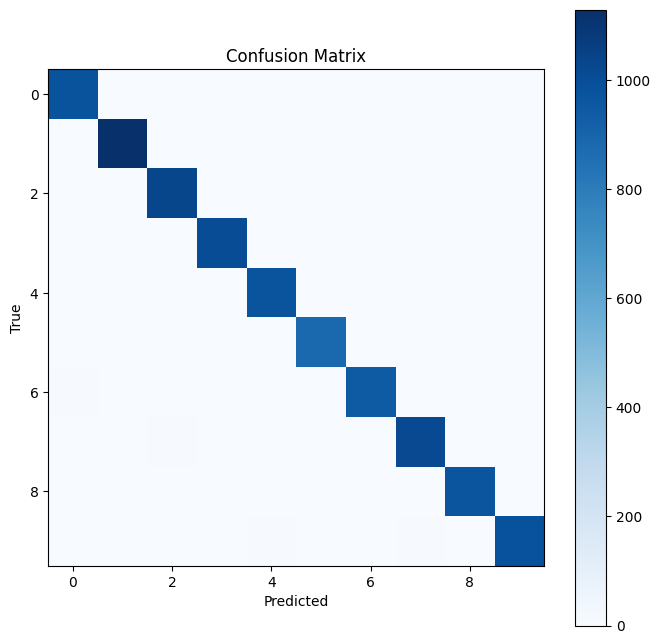


=== CNN Hold-out Evaluation ===
CNN Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.99      0.99      0.99      1032
           3       1.00      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.98      1.00      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [16]:
# Cell: Hold-out Evaluation for Both Models
# -----------------------------------------
# SNN evaluation
print("\n=== SNN Hold-out Evaluation ===")
evaluate_on_holdout(model, predictor, test_loader, device)

# CNN evaluation
print("\n=== CNN Hold-out Evaluation ===")
compare_cnn(test_loader)


=== SNN Ablation (Random ROI) ===

=== SNN Ablation (Random ROI) ===
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       980
           1       0.99      0.96      0.98      1135
           2       0.96      0.98      0.97      1032
           3       0.98      0.97      0.98      1010
           4       0.96      0.99      0.97       982
           5       0.99      0.97      0.98       892
           6       0.99      0.96      0.97       958
           7       0.98      0.96      0.97      1028
           8       0.85      0.99      0.92       974
           9       0.99      0.91      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



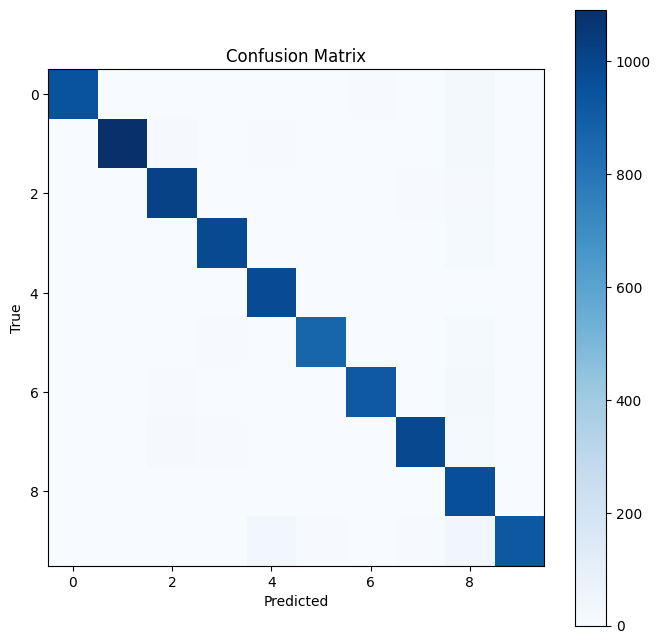


=== SNN Stress Test (Augmented Data) ===
Stress-test:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       980
           1       0.99      0.98      0.99      1135
           2       0.95      0.98      0.96      1032
           3       0.95      0.99      0.97      1010
           4       0.98      0.97      0.98       982
           5       0.98      0.94      0.96       892
           6       0.98      0.97      0.97       958
           7       0.97      0.98      0.97      1028
           8       0.96      0.97      0.96       974
           9       0.97      0.93      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000


=== CNN Stress Test (Augmented Data) ===
              precision    recall  f1-score   support

           0       0.94      0.93      0.94       980
           1       0.95      0.91  

In [17]:
# Cell: Ablation and Stress Tests
# --------------------------------
# ROI ablation (random masks) on SNN
print("\n=== SNN Ablation (Random ROI) ===")
ablation_test(test_loader)

# Data augmentation stress-test on SNN
print("\n=== SNN Stress Test (Augmented Data) ===")
stress_test(model, predictor, test_loader)

# CNN stress-test (reuse augment function)
print("\n=== CNN Stress Test (Augmented Data) ===")
# simple augment then evaluate
all_true, all_pred = [], []
with torch.no_grad():
    for vox, labels in test_loader:
        vox_aug = augment_event_tensor(vox)
        preds = cnn_model(vox_aug.float().to(device)).argmax(1).cpu().tolist()
        all_pred.extend(preds); all_true.extend(labels.tolist())
print(classification_report(all_true, all_pred, zero_division=0))

In [18]:
# Cell: k-Fold Cross-Validation Comparison (5 folds)
# ---------------------------------------------------
full_dataset = train_loader.dataset 

print("\n=== SNN k-Fold CV ===")
kfold_evaluation(full_dataset, k=5, batch_size=32, num_workers=2, pin_memory=True)

# For CNN, wrap train_one_epoch_cnn & validate_cnn similarly if desired
# Or reuse the same kfold_evaluation by swapping in CNN train/validate functions


=== SNN k-Fold CV ===


  Train:   0%|          | 0/1500 [00:00<?, ?batch/s]

  Train:   0%|          | 0/1500 [00:00<?, ?batch/s]

  Train:   0%|          | 0/1500 [00:00<?, ?batch/s]

  Train:   0%|          | 0/1500 [00:00<?, ?batch/s]

  Train:   0%|          | 0/1500 [00:00<?, ?batch/s]

  Train:   0%|          | 0/1500 [00:00<?, ?batch/s]

  Train:   0%|          | 0/1500 [00:00<?, ?batch/s]

  Train:   0%|          | 0/1500 [00:00<?, ?batch/s]

  Train:   0%|          | 0/1500 [00:00<?, ?batch/s]

  Train:   0%|          | 0/1500 [00:00<?, ?batch/s]

  Val  :   0%|          | 0/375 [00:00<?, ?batch/s]

Fold 1 macro-F1: 0.0180


  Train:   0%|          | 0/1500 [00:00<?, ?batch/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d51245427a0><function _MultiProcessingDataLoaderIter.__del__ at 0x7d51245427a0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()    
self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():    
if w.is_alive():
             ^ ^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._par

  Train:   0%|          | 0/1500 [00:00<?, ?batch/s]

  Train:   0%|          | 0/1500 [00:00<?, ?batch/s]

  Train:   0%|          | 0/1500 [00:00<?, ?batch/s]

  Train:   0%|          | 0/1500 [00:00<?, ?batch/s]

  Train:   0%|          | 0/1500 [00:00<?, ?batch/s]

  Train:   0%|          | 0/1500 [00:00<?, ?batch/s]

  Train:   0%|          | 0/1500 [00:00<?, ?batch/s]

  Train:   0%|          | 0/1500 [00:00<?, ?batch/s]

  Train:   0%|          | 0/1500 [00:00<?, ?batch/s]

  Val  :   0%|          | 0/375 [00:00<?, ?batch/s]

Fold 2 macro-F1: 0.0181


  Train:   0%|          | 0/1500 [00:00<?, ?batch/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d51245427a0>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d51245427a0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()    
self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
if w.is_alive():
     if w.is_alive():
            ^ ^^^^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^    
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/lib/python3

  Train:   0%|          | 0/1500 [00:00<?, ?batch/s]

  Train:   0%|          | 0/1500 [00:00<?, ?batch/s]

  Train:   0%|          | 0/1500 [00:00<?, ?batch/s]

  Train:   0%|          | 0/1500 [00:00<?, ?batch/s]

  Train:   0%|          | 0/1500 [00:00<?, ?batch/s]

  Train:   0%|          | 0/1500 [00:00<?, ?batch/s]

  Train:   0%|          | 0/1500 [00:00<?, ?batch/s]

  Train:   0%|          | 0/1500 [00:00<?, ?batch/s]

  Train:   0%|          | 0/1500 [00:00<?, ?batch/s]

  Val  :   0%|          | 0/375 [00:00<?, ?batch/s]

Fold 3 macro-F1: 0.0179


  Train:   0%|          | 0/1500 [00:00<?, ?batch/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d51245427a0>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7d51245427a0>Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Traceback (most recent call last):
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
self._shutdown_workers()    
self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
if w.is_alive():
       if w.is_alive():  
     ^ ^  ^ ^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/usr/lib/python

  Train:   0%|          | 0/1500 [00:00<?, ?batch/s]

  Train:   0%|          | 0/1500 [00:00<?, ?batch/s]

  Train:   0%|          | 0/1500 [00:00<?, ?batch/s]

  Train:   0%|          | 0/1500 [00:00<?, ?batch/s]

  Train:   0%|          | 0/1500 [00:00<?, ?batch/s]

  Train:   0%|          | 0/1500 [00:00<?, ?batch/s]

  Train:   0%|          | 0/1500 [00:00<?, ?batch/s]

  Train:   0%|          | 0/1500 [00:00<?, ?batch/s]

  Train:   0%|          | 0/1500 [00:00<?, ?batch/s]

  Val  :   0%|          | 0/375 [00:00<?, ?batch/s]

Fold 4 macro-F1: 0.0182


  Train:   0%|          | 0/1500 [00:00<?, ?batch/s]

  Train:   0%|          | 0/1500 [00:00<?, ?batch/s]

  Train:   0%|          | 0/1500 [00:00<?, ?batch/s]

  Train:   0%|          | 0/1500 [00:00<?, ?batch/s]

  Train:   0%|          | 0/1500 [00:00<?, ?batch/s]

  Train:   0%|          | 0/1500 [00:00<?, ?batch/s]

  Train:   0%|          | 0/1500 [00:00<?, ?batch/s]

  Train:   0%|          | 0/1500 [00:00<?, ?batch/s]

  Train:   0%|          | 0/1500 [00:00<?, ?batch/s]

  Train:   0%|          | 0/1500 [00:00<?, ?batch/s]

  Val  :   0%|          | 0/375 [00:00<?, ?batch/s]

Fold 5 macro-F1: 0.0180
Mean macro-F1: 0.0180 ± 0.0001
